In [ ]:
# Importations
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, KFold

import seaborn as sns

In [2]:
class Graphes:

    @staticmethod
    def accuracy_loss_graphe(historique):
        # Affichage accuracy - loss
        fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
        axs = axs.flatten()
        axs[0].plot(historique.history["accuracy"], label='Accuracy Train')
        axs[0].plot(historique.history["val_accuracy"], label='Accuracy Val')
        axs[0].set_title(f"Evolution de l'accuracy")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend()

        axs[1].plot(historique.history["loss"], label='Loss Train')
        axs[1].plot(historique.history["val_loss"], label='Loss Val')
        axs[1].set_title(f"Evolution de la perte")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        plt.show()

In [3]:
class ImageGenerator:

    @staticmethod
    def create_imperfect_image(image, image_size=(56, 56), seed=1):
        random.seed(seed)
        new_image = np.ones((*image_size, image.shape[2]), dtype=np.uint8)

        max_offset = image_size[0] - image.shape[0]
        random_x = random.randint(0, max_offset)
        random_y = random.randint(0, max_offset)

        new_image[random_x:random_x+image.shape[0], random_y:random_y+image.shape[1], :] = image
        return new_image

In [4]:
def generation_propre(X, y, nb=10000, seed=1):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.2,
    )

    new_images_generator = datagen.flow(X, batch_size=1, shuffle=False, seed=seed)

    X_new = X.tolist()
    y_new = y.tolist()
    for i in range(nb):
        img = next(new_images_generator)[0]
        X_new.append(img.tolist())
        y_new.append(y[i].tolist())

        if i < 1:
          plt.figure()
          plt.imshow(img, cmap="grey")
          plt.axis("off")
          plt.show()
    return np.array(X_new), np.array(y_new)


In [5]:
# Création image 56 x 56 avec chiffre positioné aléatoirement
# L'image est ensuite redimensionnée -> 28 x 28

def generation_2(X, y, nb=10000, seed=1):
    new_images = X.tolist()
    new_images_label = y.tolist()

    for i in range(nb):
        imperfect_image = ImageGenerator.create_imperfect_image(X[i], seed=i+seed)

        # imperfect_image = tf.image.resize(imperfect_image, (28, 28))
        imperfect_image = tf.expand_dims(imperfect_image, axis=0)
        imperfect_image = tf.nn.max_pool2d(imperfect_image, ksize=2, strides=2, padding="VALID")

        imperfect_image = imperfect_image.numpy().reshape(28, 28, 1)


        new_images.append(imperfect_image.tolist())
        new_images_label.append(y[i].tolist())

        if i < 1:
          plt.figure()
          plt.imshow(imperfect_image, cmap="grey")
          plt.axis("off")
          plt.show()

    new_images = np.array(new_images)
    new_images_label = np.array(new_images_label)

    return new_images, new_images_label

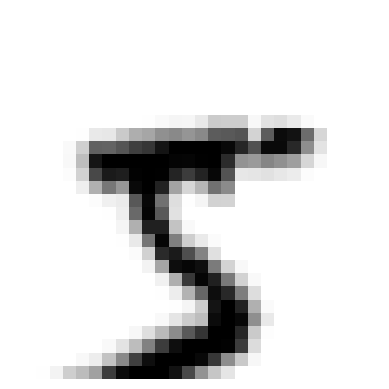

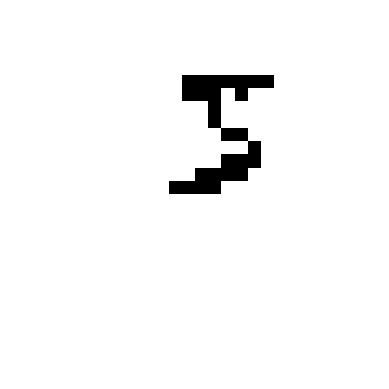

In [33]:
# Chargement et traitement des données MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Normalisation
x_train = x_train / 255.0
x_test = x_test / 255.0

# Inversion
x_train = 1 - x_train
x_test = 1 - x_test

# Génération de nouvelles données imparfaites
x_train, y_train = generation_propre(x_train, y_train, 20000)
x_train, y_train = generation_2(x_train, y_train, 25000)

# Mélange (pour validation_split)
np.random.seed(42)
indice = np.random.permutation(len(x_train))
x_train = x_train[indice]
y_train = y_train[indice]

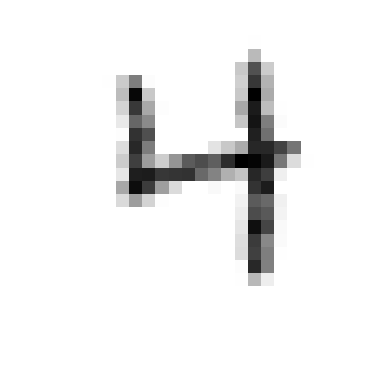

In [ ]:
# Apercu dataset
for i in range(1):
    plt.figure()
    plt.imshow(x_train[i], cmap="grey")
    plt.axis("off")
    plt.show()

In [7]:
# Optimisation Bayésienne

def build_model(hp):
    model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Flatten(),

      Dense(hp.Choice('units_1', [256, 512, 1024, 2048]), activation='relu'),
      Dropout(0.25),
      BatchNormalization(),
      Dense(hp.Choice('units_2', [256, 512, 1024, 2048]), activation='relu'),
      Dropout(0.5),
      BatchNormalization(),

      Dense(10, activation="softmax")
    ])
    optimizer = Adam(0.001, weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
)

tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=128)
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Meilleures valeurs trouvées :", best_hyperparameters.values)


Trial 16 Complete [00h 01m 12s]
val_accuracy: 0.9936000108718872

Best val_accuracy So Far: 0.9947999715805054
Total elapsed time: 00h 19m 46s
Meilleures valeurs trouvées : {'units_1': 512, 'units_2': 512}


In [83]:
# Optimisation random search

def build_model(rate_1, rate_2, rate_3, units_1, units_2, activation):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D((2,2), strides=2),
        Dropout(rate_1),

        Conv2D(64, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2,2), strides=2),
        Dropout(rate_1),

        Conv2D(128, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2,2), strides=2),
        Dropout(rate_1),

        Reshape((-1, 128)),

        Bidirectional(GRU(units_1, activation=activation, return_sequences=True)),
        Dropout(rate_2),

        Bidirectional(GRU(units_2, activation=activation)),
        Dropout(rate_3),

        Dense(10, activation="softmax")
    ])

    optimizer = Adam(learning_rate=0.001, weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

    return model

param_distributions = {
    'rate_1': [0.2, 0.3, 0.4],
    'rate_2': [0.2, 0.3, 0.4, 0.5],
    'rate_3': [0.2, 0.3, 0.4, 0.5],
    'units_1': [64, 128, 256],
    'units_2': [64, 128, 256],
    'activation': ['tanh', 'relu']
}

best_params = {'acc' : 0}
for i in range(20):
  params = []
  for i in range(len(param_distributions)):
    params.append(random.choice(param_distributions[list(param_distributions.keys())[i]]))
  model = build_model(*params)
  historique = model.fit(x_train, y_train, epochs=5, validation_split=0.2, batch_size=64, verbose=0)

  if historique.history['val_accuracy'][-1] > best_params['acc']:
    best_params['acc'] = historique.history['val_accuracy'][-1]
    best_params['params'] = params

print("Meilleurs paramètres trouvés :", best_params)


KeyboardInterrupt: 

In [23]:
# Définition du modele

def build_model():
  model = tf.keras.models.Sequential([
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(28, 28, 1)),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      Conv2D(128, (3, 3), activation='relu', padding="same"),
      BatchNormalization(),
      MaxPooling2D((2,2), strides=2),
      Dropout(0.3),

      Flatten(),

      Dense(512, activation='relu'),
      Dropout(0.25),
      BatchNormalization(),
      Dense(512, activation='relu'),
      Dropout(0.5),
      BatchNormalization(),

      Dense(10, activation="softmax")
  ])
  optimizer = Adam(learning_rate=0.001, weight_decay=0.0001)
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

  return model



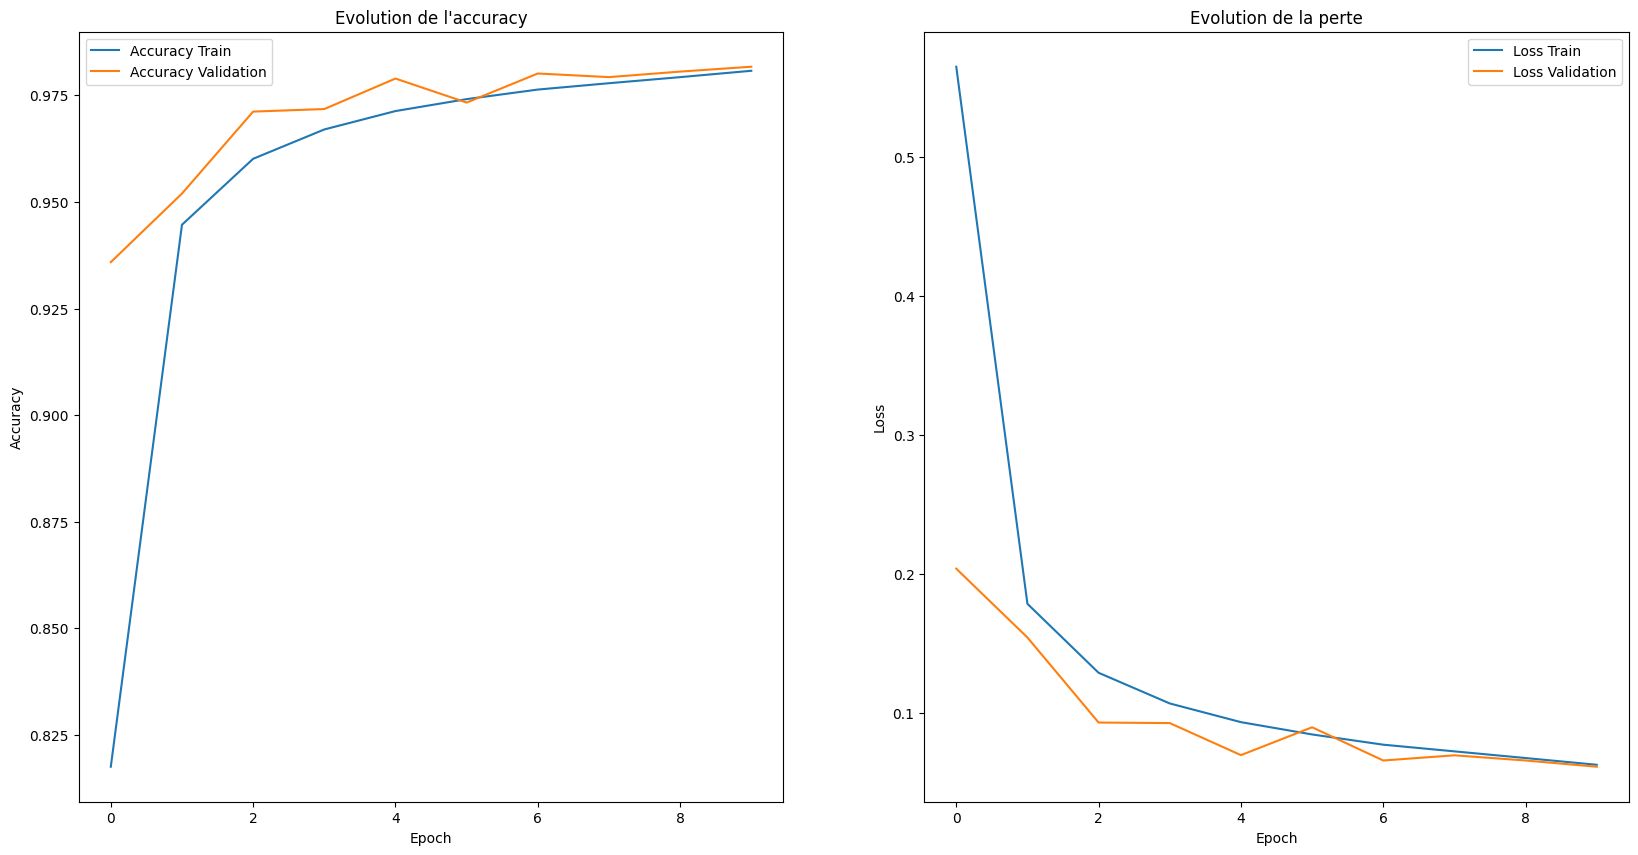

Acccuracy :  0.9807523846626282
Loss :  0.06259981617331505
Accuracy Validation :  0.9817047595977784
Loss Validation :  0.06120046749711037


In [34]:
# Entrainement - Cross validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
loss = []
val_accuracies = []
val_loss = []
i = 1

for train_index, val_index in kf.split(x_train, y_train):
    X, x_val = x_train[train_index], x_train[val_index]
    y, y_val = y_train[train_index], y_train[val_index]

    print(f"Fold {i}")
    i += 1

    model = build_model()
    historique = model.fit(X, y, epochs=10, validation_data=(x_val, y_val), batch_size=128)

    accuracies.append(historique.history["accuracy"])
    val_accuracies.append(historique.history["val_accuracy"])
    loss.append(historique.history["loss"])
    val_loss.append(historique.history["val_loss"])

    clear_output(wait=True)

accuracies = np.array(accuracies)
loss = np.array(loss)
val_accuracies = np.array(val_accuracies)
val_loss = np.array(val_loss)

accuracies = np.mean(accuracies, axis=0)
loss = np.mean(loss, axis=0)
val_accuracies = np.mean(val_accuracies, axis=0)
val_loss = np.mean(val_loss, axis=0)

# Affichage accuracy - loss
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
axs = axs.flatten()
axs[0].plot(accuracies, label='Accuracy Train')
axs[0].plot(val_accuracies, label='Accuracy Validation')
axs[0].set_title(f"Evolution de l'accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

axs[1].plot(loss, label='Loss Train')
axs[1].plot(val_loss, label='Loss Validation')
axs[1].set_title(f"Evolution de la perte")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
plt.show()

print('Acccuracy : ', accuracies[-1])
print('Loss : ', loss[-1])
print('Accuracy Validation : ', val_accuracies[-1])
print('Loss Validation : ', val_loss[-1])

In [ ]:
# Sauvegarde

model.save('mon_modele.h5')
from google.colab import files
files.download('mon_modele.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Charger
from tensorflow.keras.models import load_model

model = load_model("model/mon_modele.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'model/mon_modele.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

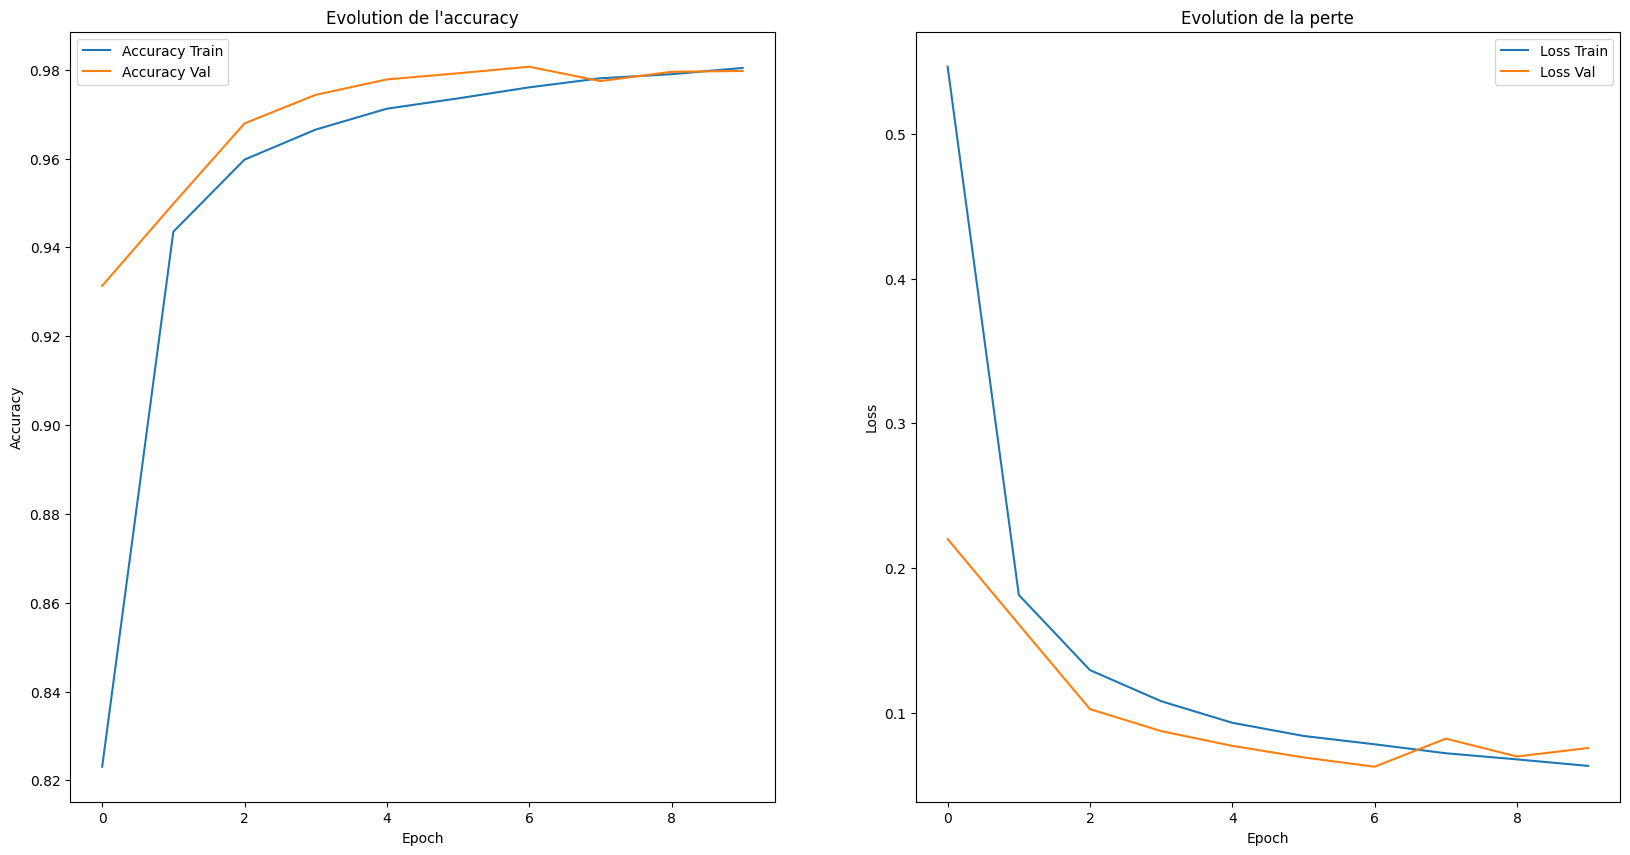

In [35]:
Graphes.accuracy_loss_graphe(historique)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      1.00      1032
           3       1.00      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      1.00      0.99       892
           6       0.99      1.00      0.99       958
           7       1.00      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



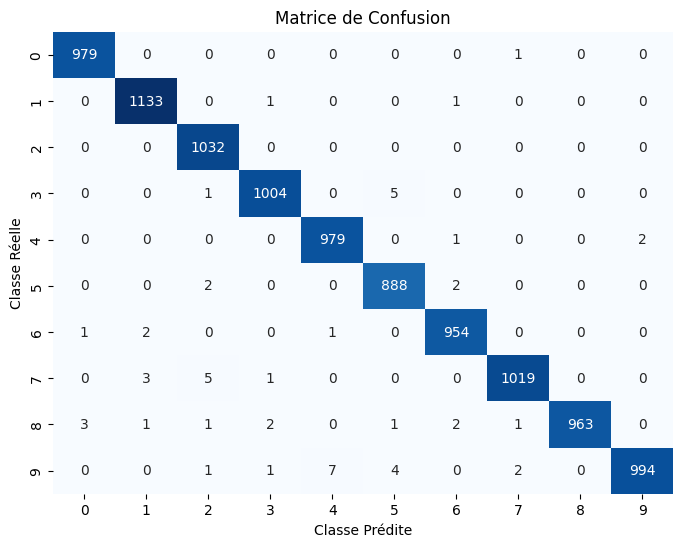

In [36]:
# Stats et matrice de confusion

predictions = np.argmax(model.predict(x_test), axis=1)

print(classification_report(y_test, predictions, target_names=["0","1","2","3","4","5", "6","7", "8", "9"]))

confusion = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_1.png", format="png")
plt.show()


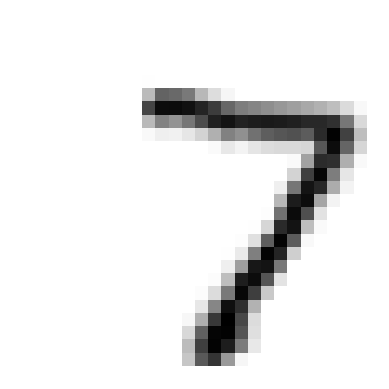

In [37]:
# generation_propre

new_images_propre, new_images_propre_label = generation_propre(x_test, y_test, nb=10000, seed=2)
new_images_propre, new_images_propre_label = new_images_propre[10000:], new_images_propre_label[10000:]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.99      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       1.00      0.96      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



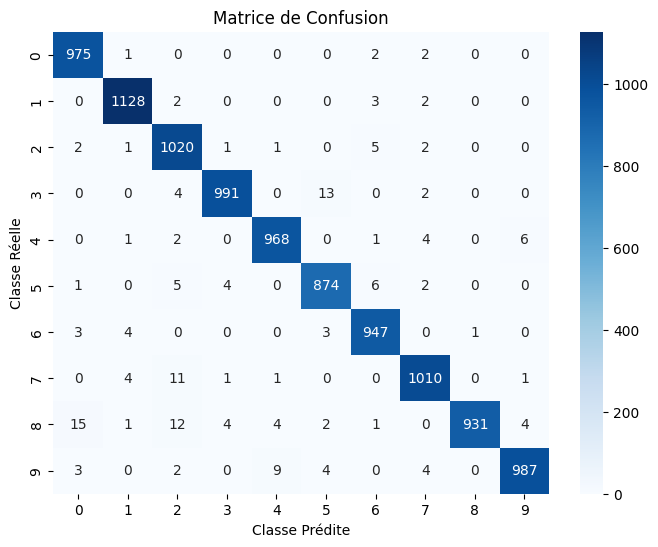

In [41]:
# Stats et matrice de confusion sur données générées (generation_propre)


# Résultat sur les nouvelles données

new_pred = np.argmax(model.predict(new_images_propre), axis=1)

print(classification_report(new_images_propre_label, new_pred))

confusion = confusion_matrix(new_images_propre_label, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_2.png", format="png")
plt.show()



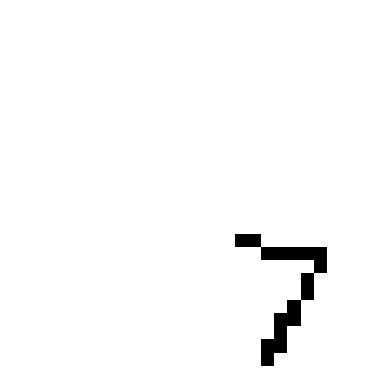

In [39]:
# generation_2
new_images, new_images_label = generation_2(x_test, y_test, seed=2)
new_images, new_images_label = new_images[10000:], new_images_label[10000:]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.91      0.99      0.95      1032
           3       0.97      0.92      0.94      1010
           4       0.94      0.95      0.95       982
           5       0.90      0.97      0.93       892
           6       0.95      0.98      0.97       958
           7       0.95      0.94      0.94      1028
           8       0.99      0.87      0.93       974
           9       0.97      0.88      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



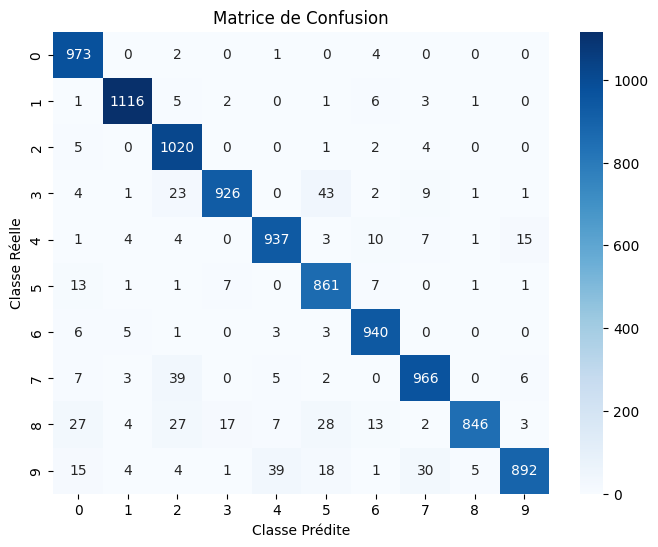

In [40]:
# Stats et matrice de confusion sur données générées (generation_2)

# Résultat sur les nouvelles données

new_pred = np.argmax(model.predict(new_images), axis=1)

print(classification_report(new_images_label, new_pred))

confusion = confusion_matrix(new_images_label, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_2.png", format="png")
plt.show()



In [42]:
# Combinaison de toutes les données

x_test_global = np.concatenate((x_test, new_images, new_images_propre))
y_test_global = np.concatenate((y_test, new_images_label, new_images_propre_label))

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2940
           1       0.99      0.99      0.99      3405
           2       0.95      0.99      0.97      3096
           3       0.99      0.96      0.97      3030
           4       0.97      0.98      0.98      2946
           5       0.95      0.98      0.97      2676
           6       0.98      0.99      0.98      2874
           7       0.97      0.97      0.97      3084
           8       1.00      0.94      0.97      2922
           9       0.99      0.95      0.97      3027

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000



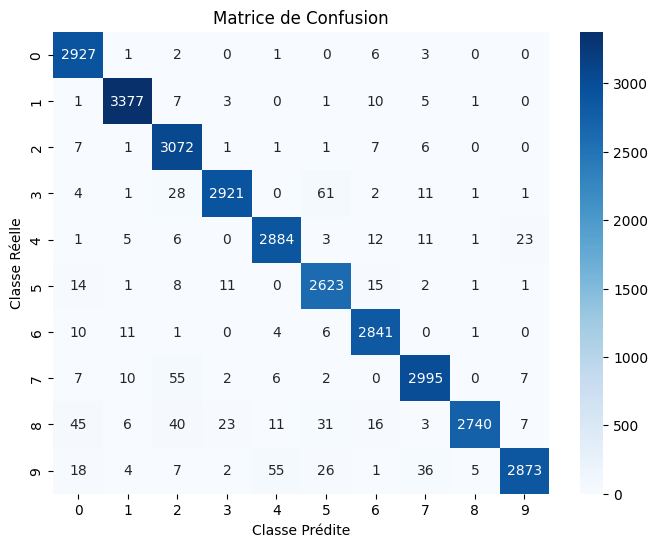

In [43]:
# Stats et matrice de confusion sur TOUTES données

new_pred = np.argmax(model.predict(x_test_global), axis=1)

print(classification_report(y_test_global, new_pred))

confusion = confusion_matrix(y_test_global, new_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=True)

plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.title("Matrice de Confusion")
#plt.savefig("img/matrice_conf_final.png", format="png")
plt.show()

